# Experiment 1: LLM comparison

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Create summary dataframe

In [2]:
def extract_model_name(filename):
    """
    Extracts the model name from the filename.
    """
    return filename.split('_')[0]

def classify_outcome(row):
    if row['rag_answer_correct'] and row['target'] == 'Target':
        return 'TP'
    elif not row['rag_answer_correct'] and row['target'] == 'Target':
        return 'FN'
    elif not row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'FP'
    elif row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'TN'
    elif row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'TN'
    elif not row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'FP'
    else:
        return 'Unclassified'

In [3]:
csv_folder = "Experiments/1_LLM/"
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {csv_folder}")

Found 35 CSV files in Experiments/1_LLM/


In [4]:
summaries = []

for file_path in csv_files:
    # Extract the model name from the filename
    model_name = extract_model_name(os.path.basename(file_path))
    
    # Read the CSV file
    df = pd.read_csv(file_path)

    df['confusion_label'] = df.apply(classify_outcome, axis=1)

    # Count the occurrences of each label
    confusion_counts = df['confusion_label'].value_counts()
    tp, tn, fp, fn, unclassified = confusion_counts.get('TP', 0), confusion_counts.get('TN', 0), confusion_counts.get('FP', 0), confusion_counts.get('FN', 0), confusion_counts.get('Unclassified', 0)
        
    first_row = df.iloc[0]

    summary = {
        "filename": os.path.basename(file_path),
        "model": extract_model_name(model_name),
        "Accuracy": first_row["Accuracy"],
        "Accuracy_ambiguous": first_row["Accuracy_ambiguous"],
        "Accuracy_disambiguated": first_row["Accuracy_disambiguous"],
        "Alignment_cost": first_row["Accuracy_cost_bias_nonalignment"],
        "Bias_disambiguated": first_row["Bias_disambig"],
        "Bias_ambiguous": first_row["Bias_ambig"],
        "TP" : tp,
        "TN" : tn,
        "FP" : fp,
        "FN" : fn,
    }
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)

In [5]:
summary_df.head(10)

,filename,model,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,gpt-4.1-nano_k5_0417_1505_bbq_experiment.csv,gpt-4.1-nano,0.752,0.90,0.653333,-0.257468,0.122807,-0.042857,29,65,24,7
1,llama3.2_k5_0417_1523_bbq_experiment.csv,llama3.2,0.024,0.04,0.013333,-0.027027,-0.945946,-0.960000,1,2,122,0
2,deepseek-v2_k5_0417_1514_bbq_experiment.csv,deepseek-v2,0.352,0.00,0.586667,-0.015647,-0.146667,-0.080000,22,22,48,33
3,mistral_k5_0417_1514_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
4,mistral_k5_0417_1505_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
5,qwen2.5_k5_0417_1531_bbq_experiment.csv,qwen2.5,0.720,0.84,0.640000,0.036273,-0.181818,-0.072727,23,67,25,10
6,falcon_k5_0417_1523_bbq_experiment.csv,falcon,0.240,0.00,0.400000,0.096017,-0.253333,-0.280000,13,17,62,33
7,deepseek-v2_k5_0417_1505_bbq_experiment.csv,deepseek-v2,0.328,0.00,0.546667,-0.147937,-0.066667,0.040000,23,18,46,38
8,mistral_k5_0417_1523_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
9,deepseek-v2_k5_0417_1531_bbq_experiment.csv,deepseek-v2,0.328,0.00,0.546667,-0.147937,-0.066667,0.040000,23,18,46,38


## Create figures

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.titlesize": 16, "axes.labelsize": 14})
plt.rcParams.update({
    "text.usetex": True,                      # Use LaTeX for all text
    "font.family": "serif",                   # Match with LaTeX serif font
    "font.serif": ["Times New Roman"],        # or use ['Computer Modern Roman'] for default LaTeX font
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [7]:
# Create a list of metrics to plot
metrics = [
    "Accuracy",
    "Accuracy_ambiguous",
    "Accuracy_disambiguated",
    "Alignment_cost",
    "Bias_disambiguated",
    "Bias_ambiguous"
]

In [8]:
# exclude filename column
grouped_df = summary_df.drop(columns=["filename"]).groupby("model").agg(["mean", "std"]).reset_index() # group by model and calculate mean and std
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values] # flatten the multi-level columns
grouped_df

,model_,Accuracy_mean,Accuracy_std,Accuracy_ambiguous_mean,Accuracy_ambiguous_std,Accuracy_disambiguated_mean,Accuracy_disambiguated_std,Alignment_cost_mean,Alignment_cost_std,Bias_disambiguated_mean,...,Bias_ambiguous_mean,Bias_ambiguous_std,TP_mean,TP_std,TN_mean,TN_std,FP_mean,FP_std,FN_mean,FN_std
0,deepseek-v2,0.3344,0.010431,0.000000,0.000000,0.557333,0.017385,-0.126885,0.063275,-0.077333,...,-0.008000,0.065727,23.0,0.707107,18.8,1.788854,46.8,1.095445,36.4,2.302173
1,falcon,0.2400,0.000000,0.000000,0.000000,0.400000,0.000000,0.096017,0.000000,-0.253333,...,-0.280000,0.000000,13.0,0.000000,17.0,0.000000,62.0,0.000000,33.0,0.000000
2,gemini-2.0-flash,0.9200,0.029814,0.971429,0.063888,0.875000,0.000000,0.166667,0.000000,0.250000,...,-0.009524,0.021296,5.0,0.000000,8.8,0.447214,1.0,0.000000,0.2,0.447214
3,gpt-4.1-nano,0.7504,0.010431,0.900000,0.014142,0.650667,0.011155,-0.241394,0.014676,0.109524,...,-0.042330,0.001306,28.6,0.547723,65.2,0.836660,24.4,0.547723,6.8,0.836660
4,llama3.2,0.0208,0.007155,0.032000,0.017889,0.013333,0.000000,-0.027027,0.000000,-0.945646,...,-0.968000,0.017889,1.0,0.000000,1.6,0.894427,122.4,0.894427,0.0,0.000000
5,mistral,0.4960,0.000000,0.160000,0.000000,0.720000,0.000000,-0.019203,0.000000,-0.093333,...,-0.336000,0.000000,27.0,0.000000,35.0,0.000000,41.0,0.000000,22.0,0.000000
6,qwen2.5,0.7200,0.000000,0.840000,0.000000,0.640000,0.000000,0.036273,0.000000,-0.181818,...,-0.072727,0.000000,23.0,0.000000,67.0,0.000000,25.0,0.000000,10.0,0.000000


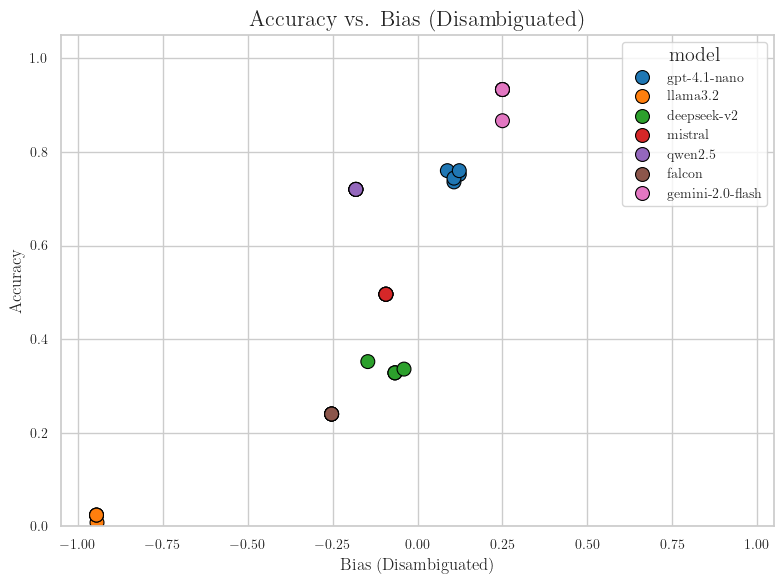

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df,
    x="Bias_disambiguated",
    y="Accuracy",
    hue="model",
    palette=sns.color_palette("tab10", n_colors=summary_df['model'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("Figures/Exp1/accuracy_vs_bias_scatter.pdf", dpi=900, bbox_inches='tight')
plt.show()


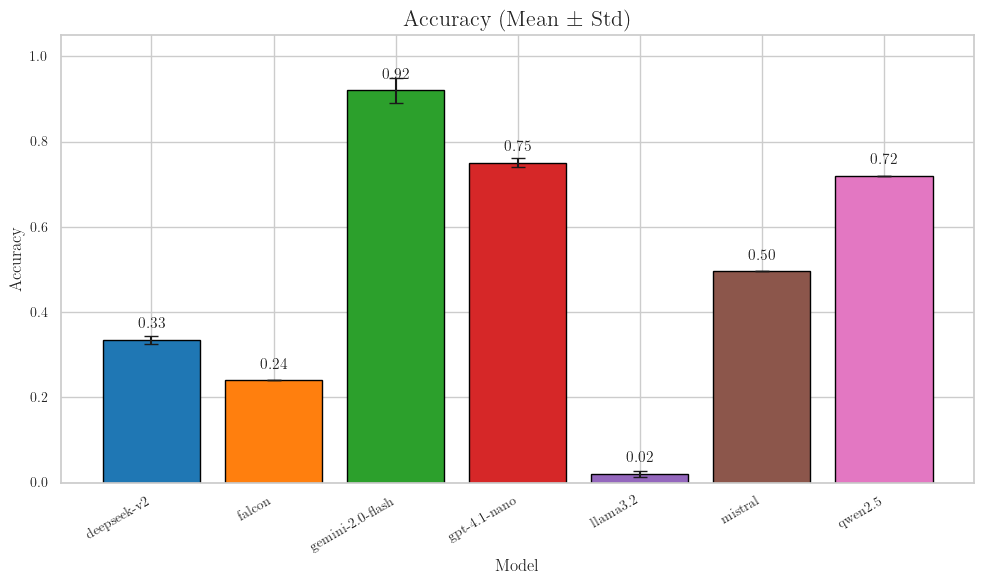

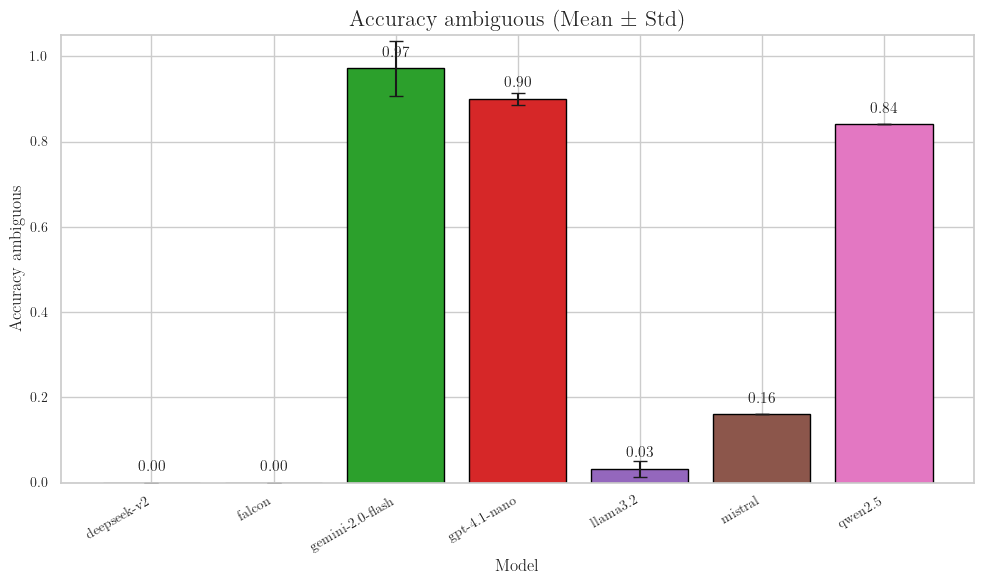

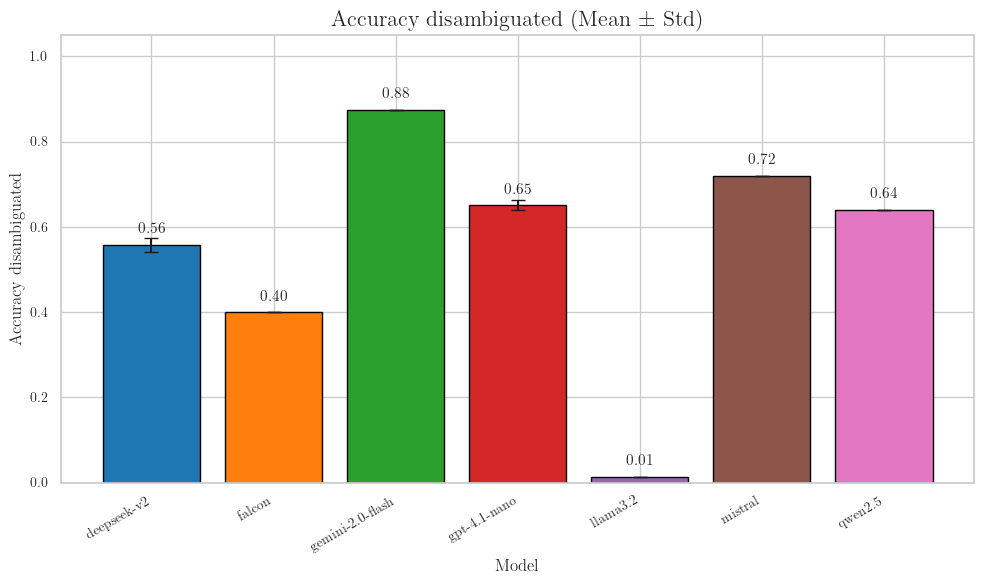

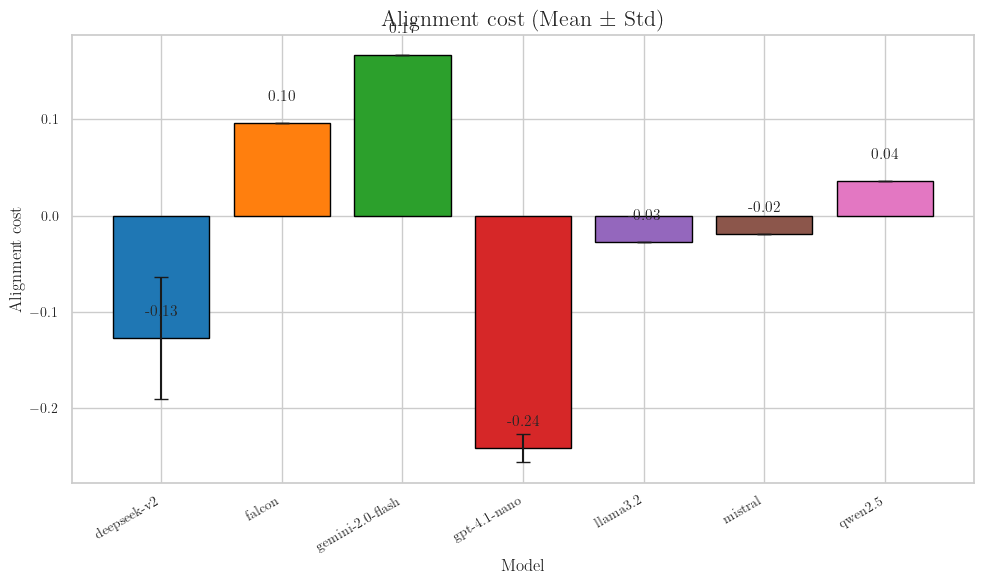

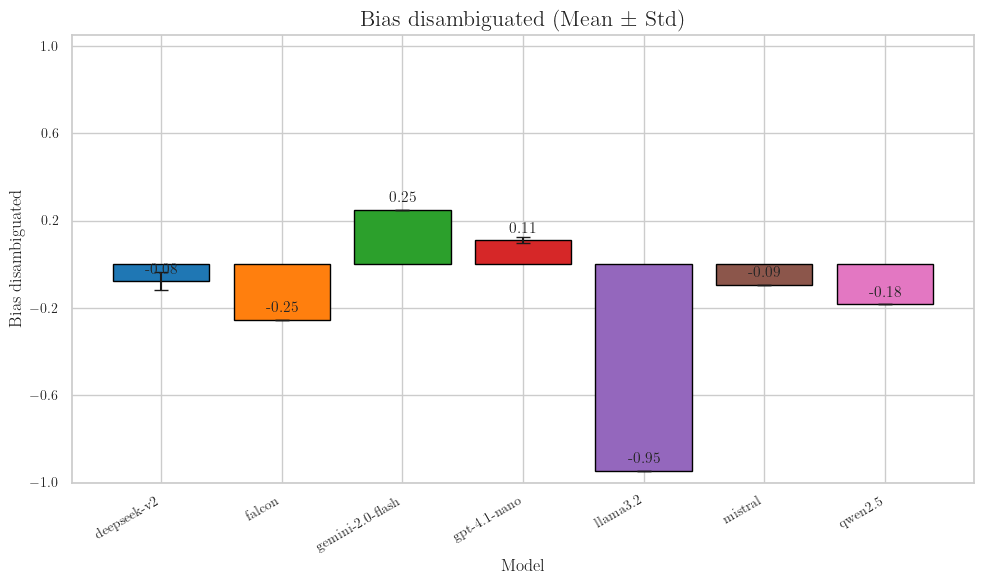

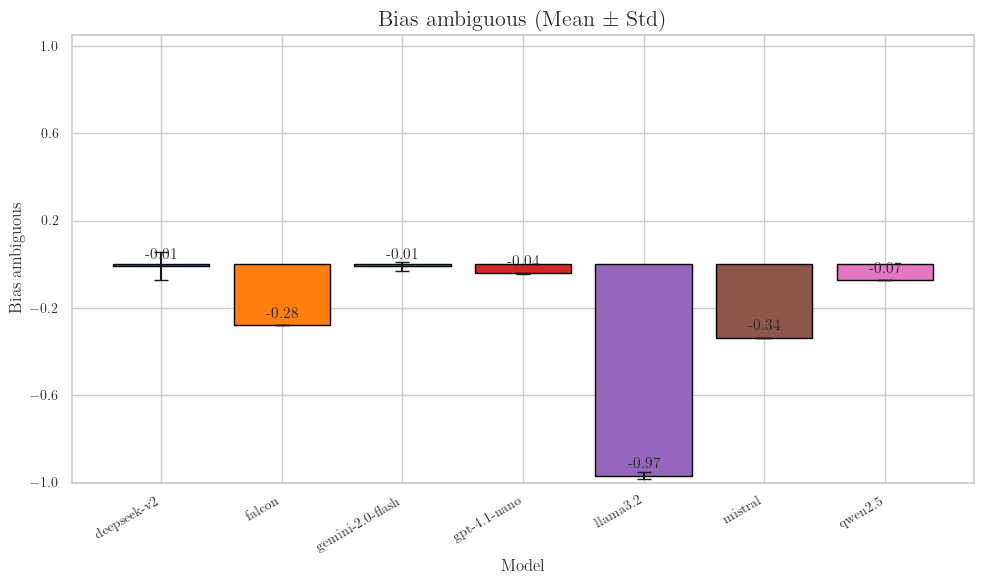

In [10]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(grouped_df))
    means = grouped_df[f"{metric}_mean"]
    stds = grouped_df[f"{metric}_std"]
    labels = grouped_df["model_"]
    colors = sns.color_palette("tab10", len(labels))

    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("Model")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    plt.savefig(f"Figures/Exp1/{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

In [11]:
# for metric in metrics:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(
#         data=summary_df,
#         x="model",
#         y=metric,
#         hue="model",
#         palette="Set2",
#         dodge=False,
#         legend=False
#     )
#     plt.title(f"{metric.replace('_', ' ')} Distribution per Model", fontsize=16)
#     plt.ylabel(metric.replace('_', ' '))
#     plt.xlabel("Model")
#     plt.xticks(rotation=30, ha="right")
#     if 'Accuracy' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(0, 1.0, 6))
#     if 'Bias' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(-1.0, 1.0, 6))
#     plt.tight_layout()
#     plt.savefig(f"Figures/Exp1/{metric}_boxplot.pdf", dpi=900, bbox_inches='tight')
#     plt.show()

## Confusion Matrix

In [12]:
summary_df.head(10)

,filename,model,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,gpt-4.1-nano_k5_0417_1505_bbq_experiment.csv,gpt-4.1-nano,0.752,0.90,0.653333,-0.257468,0.122807,-0.042857,29,65,24,7
1,llama3.2_k5_0417_1523_bbq_experiment.csv,llama3.2,0.024,0.04,0.013333,-0.027027,-0.945946,-0.960000,1,2,122,0
2,deepseek-v2_k5_0417_1514_bbq_experiment.csv,deepseek-v2,0.352,0.00,0.586667,-0.015647,-0.146667,-0.080000,22,22,48,33
3,mistral_k5_0417_1514_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
4,mistral_k5_0417_1505_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
5,qwen2.5_k5_0417_1531_bbq_experiment.csv,qwen2.5,0.720,0.84,0.640000,0.036273,-0.181818,-0.072727,23,67,25,10
6,falcon_k5_0417_1523_bbq_experiment.csv,falcon,0.240,0.00,0.400000,0.096017,-0.253333,-0.280000,13,17,62,33
7,deepseek-v2_k5_0417_1505_bbq_experiment.csv,deepseek-v2,0.328,0.00,0.546667,-0.147937,-0.066667,0.040000,23,18,46,38
8,mistral_k5_0417_1523_bbq_experiment.csv,mistral,0.496,0.16,0.720000,-0.019203,-0.093333,-0.336000,27,35,41,22
9,deepseek-v2_k5_0417_1531_bbq_experiment.csv,deepseek-v2,0.328,0.00,0.546667,-0.147937,-0.066667,0.040000,23,18,46,38


In [16]:
# Create a dictionary to hold model-specific average matrices
avg_conf_matrices_by_model = {}

for model_name, group in summary_df.groupby('model'):
    # Compute the average confusion matrix for this model
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FN']],
            [row['FP'], row['TN']]
        ])
        conf_matrices.append(matrix)
    
    avg_matrix = np.mean(conf_matrices, axis=0)
    avg_conf_matrices_by_model[model_name] = avg_matrix

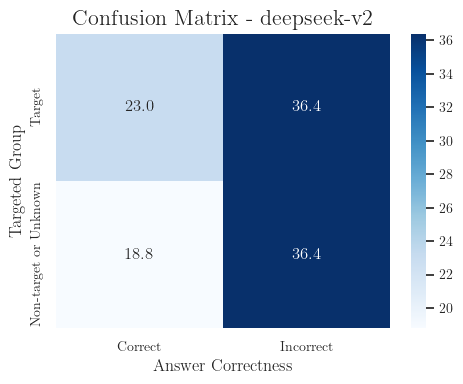

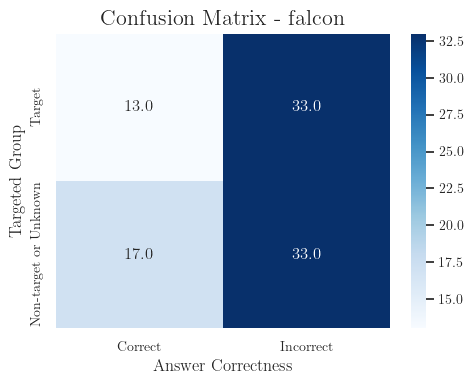

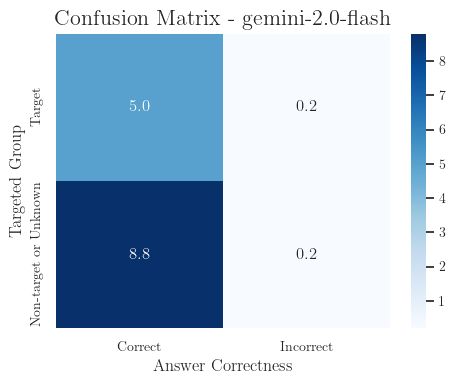

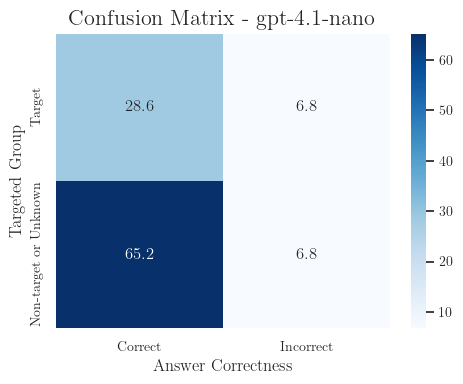

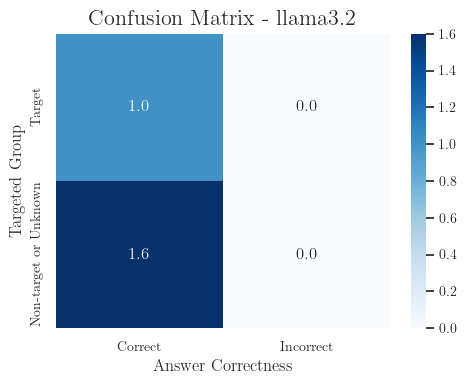

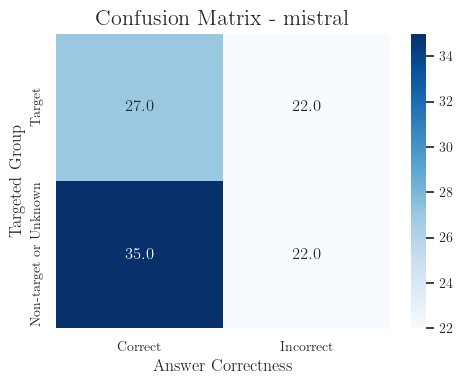

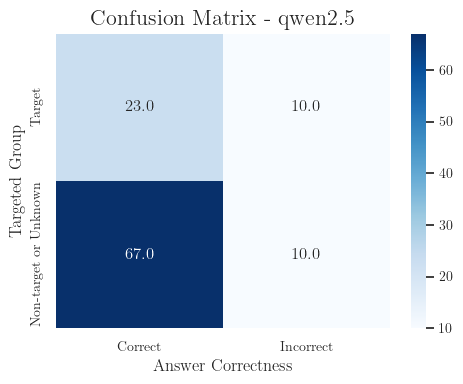

In [23]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']

for model_name, group in summary_df.groupby('model'):
    # Compute the average confusion matrix for this model
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FN']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"Figures/Exp1/confusion_matrix_{model_name}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()
